###Ý tưởng:
- Sử dụng opencv cắt frame ảnh ra từ video
- Dùng MTCNN để detech faces từ ảnh
- Tạo dataset
- Đưa vào FaceNet để tính ra embedding vector và extracting face features
- Dùng SVM để dự đoán người từ faces embeddings

In [ ]:
! nvidia-smi

Tue Oct  6 14:20:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/train
!ls

/content/drive/My Drive/train
Duc   Hieu  Kien  Quan	Thang	Tuan  VietDuc
HDuc  Hung  Linh  Tan	Truong	Van   XuanAnh


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [ ]:
import numpy as np
import pandas as pd 
import cv2 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os


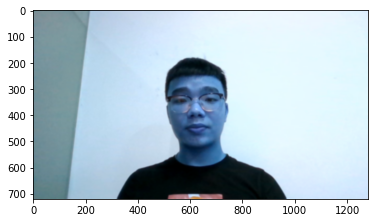

(720, 1280, 3)


In [ ]:
img = cv2.imread('/content/drive/My Drive/CW2/train/Tuan/frame0.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

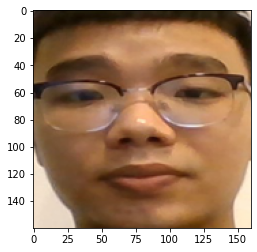

(160, 160, 3)


In [ ]:
# detech mặt từ ảnh
def extract_face(filename, required_size=(160, 160)):
    # load ảnh từ filename
    image = Image.open(filename)
    # chuyển sang ảnh màu RGB
    image = image.convert('RGB')
    # convert sang array
    pixels = np.asarray(image)
    # detech mặt bằng MTCNN
    # Tạo 1 detector từ class MTCNN. Hàm detect_faces để phát hiện các khuôn mặt trong bức hình
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    # Kết cả results trả về bao gồm 1 list các bouding boxes trong đó có tọa độ 2 mắt, mũi, miệng. Và kèm theo cả độ tin tưởng của các bounding boxes này nữa
    # nếu ko detech được thì trả về None
    if results == []:
      return None
    # cắt mặt ra từ ảnh detech
    x1, y1, width, height = results[0]['box']

    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height

    face = pixels[y1:y2, x1:x2]
    # resize ảnh về kích thước 160*160
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load thử 1 ảnh và trích xuất ra mặt
pixels = extract_face('/content/drive/My Drive/CW2/train/Tuan/frame0.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [ ]:
# Hàm cắt mặt từ dataset
def load_face(dir):
    faces = []
    
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        if face is None:
          continue

        faces.append(face)
    return faces

def load_dataset(dir):
    # X: faces, y: labels
    X, y = [], []
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/drive/My Drive/CW2/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/My Drive/CW2/val/')
print(testX.shape, testy.shape)

# lưu dataset
np.savez_compressed('cw2-faces-dataset.npz', trainX, trainy, testX, testy)
        

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# load the face dataset
data = np.load('cw2-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (1542, 160, 160, 3) (1542,) (204, 160, 160, 3) (204,)


In [ ]:
# load the facenet model
facenet_model = load_model('/content/drive/My Drive/CW2/facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [ ]:
# embedding
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert mỗi ảnh trong tập train set thành embedding
emdTrainX = []
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert mỗi ảnh trong tập test set thành embedding
emdTestX = []
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# lưu lại embedding vector
np.savez_compressed('cw2-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(1542, 128)
(204, 128)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=1542, test=204
Accuracy: train=99.935, test=99.020


Predicted: 
['Duc' 'HDuc' 'Hieu' 'Hung' 'Kien' 'Linh' 'Quan' 'Tan' 'Thang' 'Truong'
 'Tuan' 'Van' 'VietDuc' 'XuanAnh'] 
[6.19200157e-02 1.22885448e-01 2.95727614e-01 2.08445376e-01
 2.96182134e-01 3.46455865e-02 9.78950995e+01 2.77821023e-01
 3.53528441e-02 3.30321226e-01 7.34796795e-02 1.39683390e-01
 2.11752995e-01 1.66831778e-02]
Expected: Quan


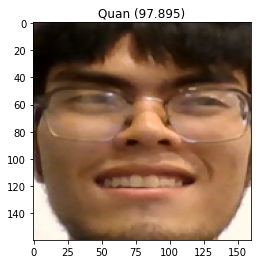

In [ ]:
#Chọn ngẫu nhiên từ tập test set để test và xem độ chính xác
from random import choice
# select face ngẫu nhiên từ test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

In [ ]:
import pickle
# Save model
pkl_filename = "/content/drive/My Drive/train/cw2_faces_svm.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
 
print("Saved model")

Saved model
